### 폴더 생성

In [ ]:
! mkdir -p./models
! mkdir -p ./images

### 이미지 다운로드

In [ ]:
# 기본 제공 이미지입니다. 여러분만의 이미지로 바꿔보세요!
! wget https://d3s0tskafalll9.cloudfront.net/media/images/E-14-3.max-800x600_KwXP73b.png
! mv E-14-3.max-800x600_KwXP73b.png ./images/my_image.png

### 패키지 다운로드

In [ ]:
!pip install opencv-python pixellib

### 패키지 선언

In [1]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

print(cv2.__version__)

4.11.0


## Step 1. 인물모드 직접 해 보기

### HumanSegmentation 클래스 구현
- read_image: 이미지를 읽고 RGB로 변환하여 반환
- predict:
      - 배경(0)이 아닌 모든 객체를 마스크로 생성
      - 클래스 명(str)에 따라 특정 클래스만 탐지
- get_bitwise_bg : bitwise_not과 bitwise_and를 사용하여 사람이 사라진 배경만 추출
- get_object_blur: 배경은 그대로 두고, binary_mask가 255인 영역(객체)만 블러 처리
- show_overlay: 원본 위에 마스크를 반투명하게 덧씌움

In [2]:
class HumanSegmentation:
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = deeplabv3_resnet101(pretrained=True).to(self.device).eval()
        self.transform = T.Compose([
            T.ToPILImage(),
            T.Resize((520, 520)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.LABEL_NAMES = [
            'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
            'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
            'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
        ]

    def read_image(self, path):
        """이미지를 읽고 RGB로 변환하여 반환"""
        img = cv2.imread(path)
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    def predict(self, img, target_name=None, threshold=None):
        """
        - target_name=None(기본값): 배경(0)이 아닌 모든 객체를 마스크로 생성
        - target_name= 클래스 명(str): 특정 클래스만 탐지
        """
        input_tensor = self.transform(img).unsqueeze(0).to(self.device)
        with torch.no_grad():
            output = self.model(input_tensor)["out"][0] # (21, H, W)

            # --- Case 1: Threshold가 없을 때 (Argmax) ---
            if threshold is None:
                output_predictions = output.argmax(0).byte().cpu().numpy()
                raw_mask = cv2.resize(output_predictions, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
                
                if target_name is None:
                    binary_mask = (raw_mask > 0).astype(np.uint8) * 255
                else:
                    target_id = self.LABEL_NAMES.index(target_name)
                    binary_mask = (raw_mask == target_id).astype(np.uint8) * 255
                
                return raw_mask, binary_mask

            # --- Case 2: Threshold가 있을 때 (Softmax) ---
            else:
                probs = torch.softmax(output, dim=0)
                
                if target_name is None:
                    # 배경(index 0)이 아닐 확률이 threshold보다 높은 곳들
                    prob_mask = (1.0 - probs[0]).cpu().numpy()
                else:
                    target_id = self.LABEL_NAMES.index(target_name)
                    prob_mask = probs[target_id].cpu().numpy()
                
                # 원본 크기로 리사이즈
                prob_mask = cv2.resize(prob_mask, (img.shape[1], img.shape[0]))
                binary_mask = (prob_mask > threshold).astype(np.uint8) * 255
                
                return prob_mask, binary_mask

    def _refine_mask(self, img, mask):
        """원본 이미지의 경계를 참조하여 마스크를 부드럽게 깎음"""
        # OpenCV의 Guided Filter는 ximgproc 모듈이 필요할 수 있습니다. 
        # 없을 경우 GaussianBlur로 대체
        try:
            guide = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            refined = cv2.ximgproc.guidedFilter(guide=guide, src=mask, radius=10, eps=1e-2)
            return refined
        except:
            return cv2.GaussianBlur(mask, (7, 7), 0)

    def _apply_clahe(self, img):
        """이미지의 대비를 높여 어두운 곳의 인물을 더 잘 찾게 함"""
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        cl = clahe.apply(l)
        limg = cv2.merge((cl,a,b))
        return cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

    def blur_original(self, img_orig, kernel=(13, 13)):
        """
        img_orig_blur = cv2.blur(img_orig, (13, 13)) 로직 구현
        """
        return cv2.blur(img_orig, kernel)
    
    def get_blur(self, mask, kernel_size=13):
        return cv2.GaussianBlur(mask, (kernel_size, kernel_size), 0)

    def get_bitwise_bg(self, img_orig_blur, mask):
        """
        bitwise_not과 bitwise_and를 사용하여 사람이 사라진 배경만 추출
        """
        # 1. 마스크를 3채널로 변환 (img_mask_color)
        mask_color = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
        # 2. 배경 마스크 생성 (bitwise_not: 사람이 0, 배경이 255)
        img_bg_mask = cv2.bitwise_not(mask_color)
        # 3. 배경만 있는 영상 획득 (bitwise_and)
        img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
        return img_bg_blur

    def get_object_blur(self, img_orig, binary_mask, kernel_size=21):
        """
        배경은 그대로 두고, binary_mask가 255인 영역(객체)만 블러 처리
        """
        # 1. 원본 이미지를 전체적으로 블러 처리한 복사본 생성
        img_blurred = cv2.blur(img_orig, (kernel_size, kernel_size))
        
        # 2. 마스크를 3채널로 변환 (RGB 이미지와 크기를 맞추기 위함)
        mask_3ch = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2RGB)
        
        # 3. 마스크가 255인 곳은 블러된 이미지를, 0인 곳은 원본 이미지를 선택
        # 결과: 객체(블러) + 배경(원본)
        return np.where(mask_3ch == 255, img_blurred, img_orig)
        
    def concat_result(self, mask, img_a, img_b):
        """np.where(mask==255, img_a, img_b) 로직 구현"""
        mask_color = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
        return np.where(mask_color == 255, img_a, img_b)

    def get_blend(self, fg, bg, mask):
        """배경 합성 기능 (별도 메서드)"""
        bg_resized = cv2.resize(bg, (fg.shape[1], fg.shape[0]))
        mask_3ch = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
        return np.where(mask_3ch > 127, fg, bg_resized)

    def show_overlay(self, img_orig, mask):
        """
        원본 위에 마스크를 반투명하게 덧씌움
        """
        color_mask = np.zeros_like(img_orig)
        color_mask[mask == 255] = [255, 0, 0]  # 객체 영역을 빨간색으로 설정
        
        # 사용자님이 주신 addWeighted 로직
        img_show = cv2.addWeighted(img_orig, 0.6, color_mask, 0.4, 0.0)
        
        plt.figure(figsize=(6, 6))
        plt.imshow(img_show) # RGB 변환은 load_img에서 이미 완료됨
        plt.title("Overlay Check (addWeighted)")
        plt.axis('off')
        plt.show()

    def img_show(self, img1, img2=None, is_mask=False, cmap=None):
        # 1. 사용할 이미지들을 리스트에 담기
        imgs = [img1]
        if img2 is not None:
            imgs.append(img2)
        
        num_imgs = len(imgs)
        plt.figure(figsize=(5 * num_imgs, 5))
    
        for i, img in enumerate(imgs):
            plt.subplot(1, num_imgs, i + 1)
            
            # 핵심 로직: cmap이 전달되면 모든 이미지에 적용, 아니면 기본 출력
            if cmap:
                # jet일 경우에만 시각적 편의를 위해 alpha 0.7 적용
                alpha = 0.7 if cmap == 'jet' else 1.0
                plt.imshow(img, cmap=cmap, alpha=alpha)
            else:
                plt.imshow(img)
            plt.axis('off')
    
        plt.tight_layout()
        plt.show()

## 이미지 합성 code 구현 - cat 

In [3]:
tool = HumanSegmentation()

/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# 1. 데이터 준비
bg = tool.read_image("./images/sand.png")

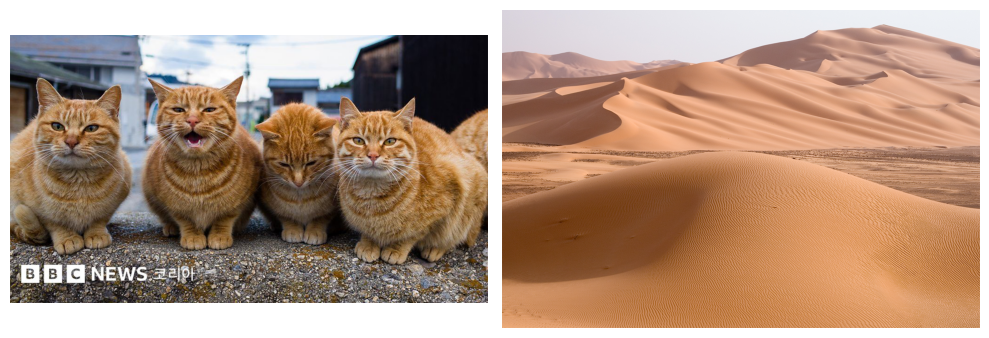

In [5]:
img = tool.read_image("./images/cat.png")
tool.img_show(img, bg)

###  2. 마스크 추출 (핵심!)

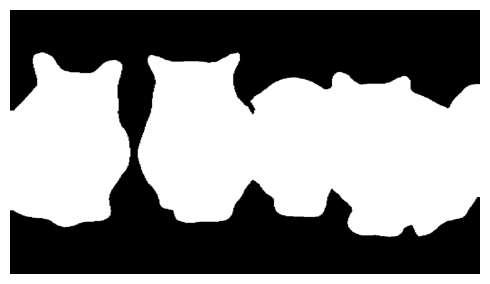

In [6]:
raw_mask, binary_mask = tool.predict(img)
tool.img_show(raw_mask, is_mask=True, cmap = 'gray')

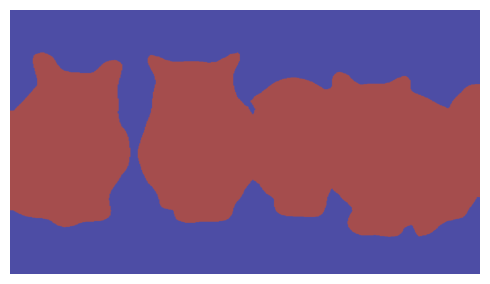

In [7]:
tool.img_show(raw_mask, cmap='jet')

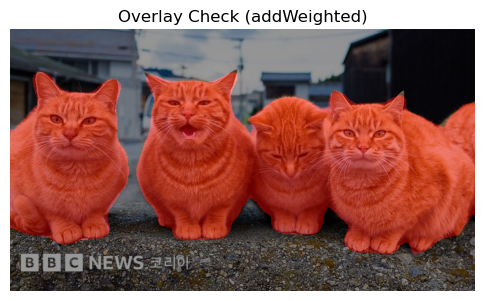

In [8]:
tool.show_overlay(img, binary_mask)

### 원본 이미지 속 객체와 배경 합성

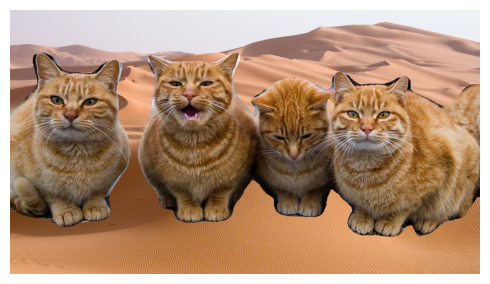

In [9]:
blurred = tool.get_blur(binary_mask)
result_img = tool.get_blend(img, bg, blurred)
tool.img_show(result_img)

### my_image의 문제점
1. 탐지된 객체 뒤에 있는 옷이 동일한 객체로 분류됨
2. 탐지된 객체가 앉고 있는 의자도 동일한 객체로 분류됨
    - 이상하게 탐지된 이미지를 crop해서 경계선을 학습시키는 모델을 개발한다
3. 탐지된 객체의 bounding box의 마진이 크기 때문에 배경과 합성 후 자연스럽지 않음

### 원본 이미지 블러 처리 과정 - person

In [10]:
img = tool.read_image("./images/my_image.png")

In [11]:
raw_mask, binary_mask = tool.predict(img)

In [12]:
img_orig_blur = tool.blur_original(img)
img_bg_blur = tool.get_bitwise_bg(img_orig_blur, raw_mask)

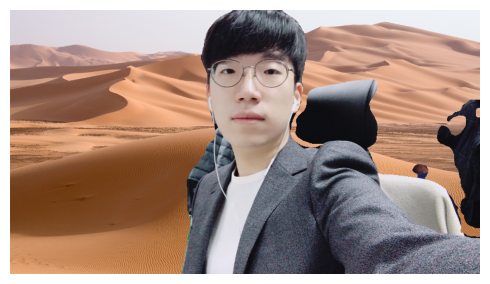

In [13]:
blurred = tool.get_blur(binary_mask)
result_img = tool.get_blend(img, bg, blurred)
tool.img_show(result_img)

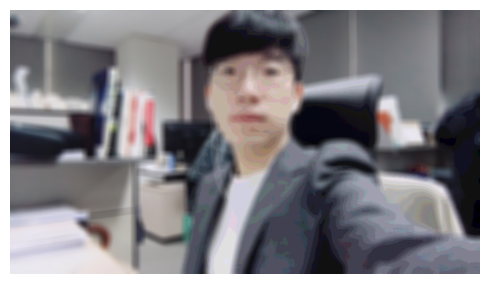

In [14]:
result_a = tool.concat_result(raw_mask, img, img_bg_blur)
tool.img_show(result_a)

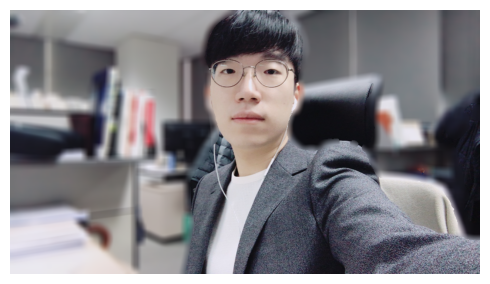

In [15]:
result_b = tool.concat_result(blurred, img, img_orig_blur)
tool.img_show(result_b)

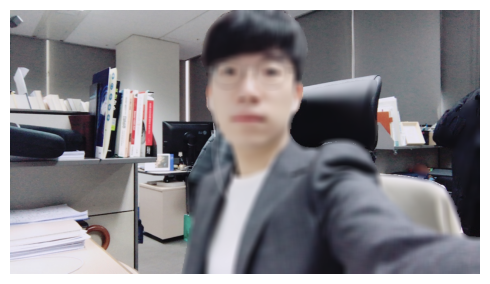

In [16]:
blurred_person_img = tool.get_object_blur(img, binary_mask, kernel_size=12)
tool.img_show(blurred_person_img)

## Step 2. 사진에서 문제점 찾기

### case1 원본 이미지와 배경의 구분이 명확하지 않을 때

In [17]:
bg = tool.read_image("./images/beach.jpg")

In [18]:
img1 = tool.read_image("./images/karina.jpg")

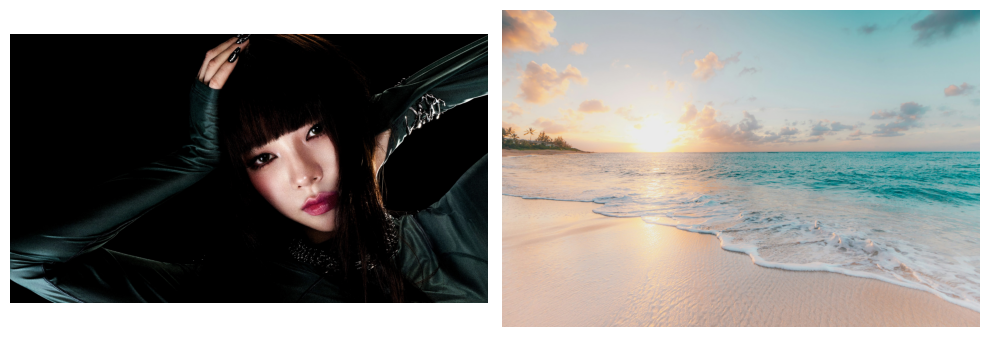

In [19]:
tool.img_show(img1, bg)

In [20]:
raw_mask1, binary_mask1 = tool.predict(img1)

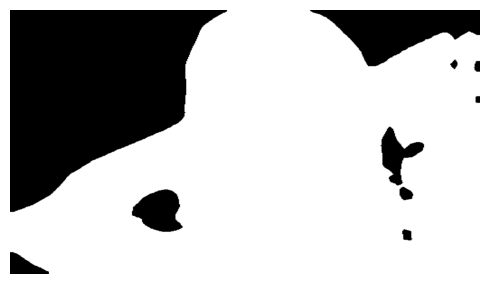

In [21]:
tool.img_show(raw_mask1, is_mask=True, cmap = 'gray')

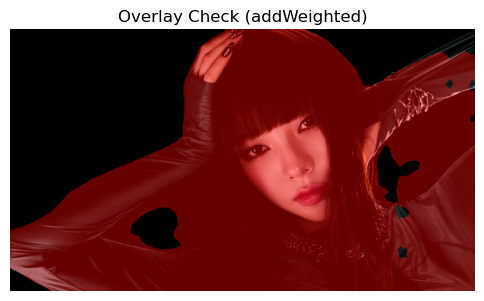

In [22]:
tool.show_overlay(img1, binary_mask1)

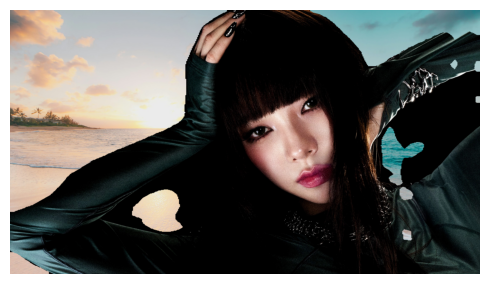

In [23]:
blurred1 = tool.get_blur(binary_mask1)
result_img1 = tool.get_blend(img1, bg, blurred1)
tool.img_show(result_img1)

### case2 원본 이미지의 해상도가 낮은 경우

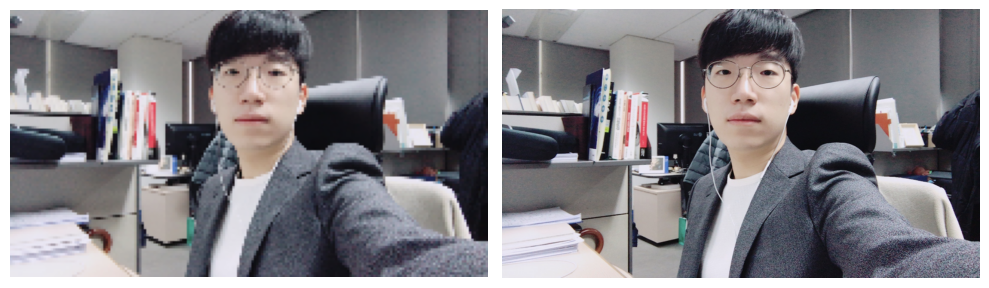

In [24]:
img2 = tool.read_image("./images/my_image.png")
img2_resized = cv2.resize(img2, (0, 0), fx=0.25, fy=0.25)

tool.img_show(img2_resized, img2)

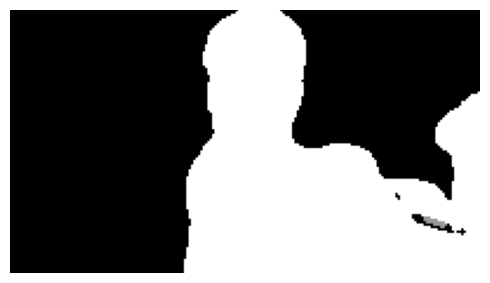

In [25]:
# 2. 마스크 추출 (핵심!)
raw_mask_resized, binary_mask_resized = tool.predict(img2_resized)
tool.img_show(raw_mask_resized, is_mask=True, cmap = 'gray')

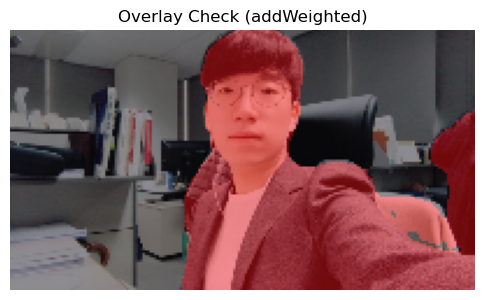

In [26]:
tool.show_overlay(img2_resized, binary_mask_resized)

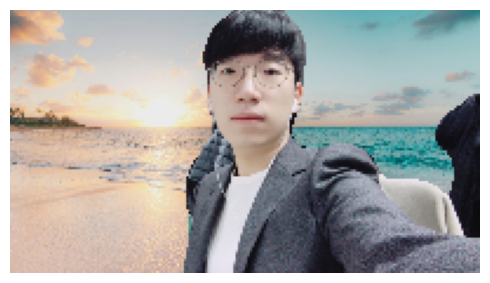

In [27]:
blurred_resized = tool.get_blur(binary_mask_resized)
result_img_resized = tool.get_blend(img2_resized, bg, blurred_resized)
tool.img_show(result_img_resized)

### case3 학습되지 않은 클래스

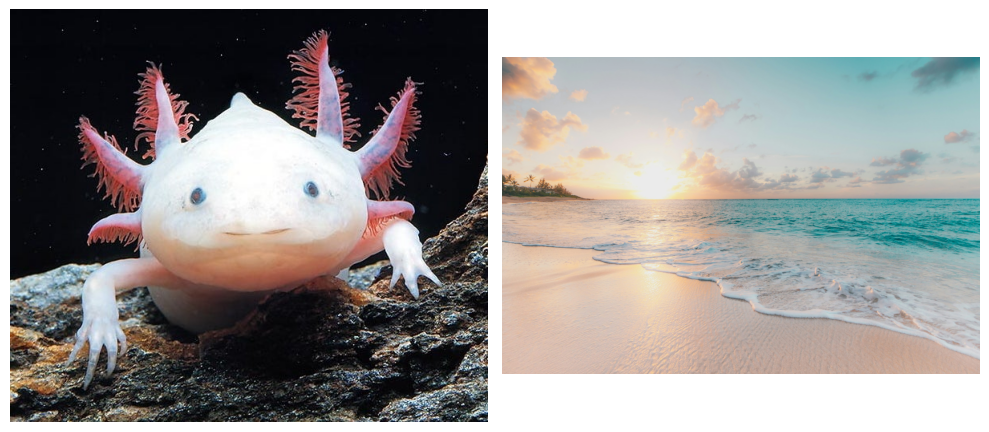

In [28]:
img = tool.read_image("./images/upa.jpg")
tool.img_show(img, bg)

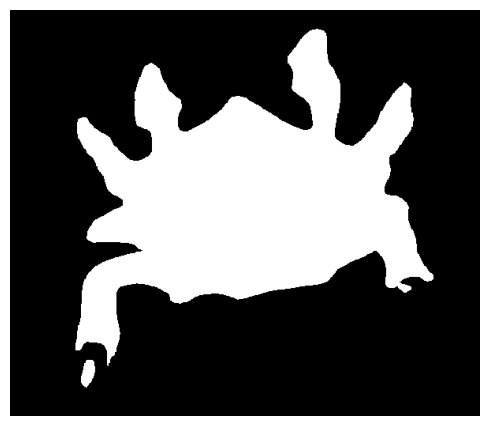

In [29]:
raw_mask, binary_mask = tool.predict(img)
tool.img_show(raw_mask, is_mask=True, cmap = 'gray')

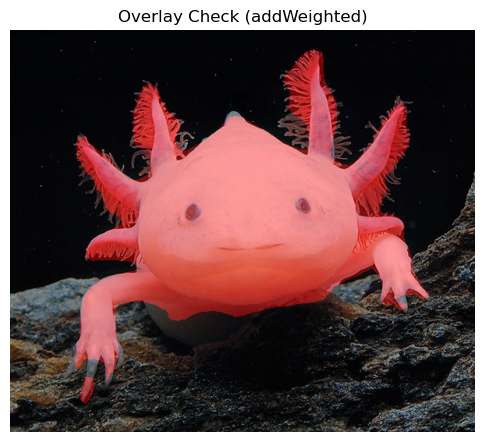

In [30]:
tool.show_overlay(img, binary_mask)

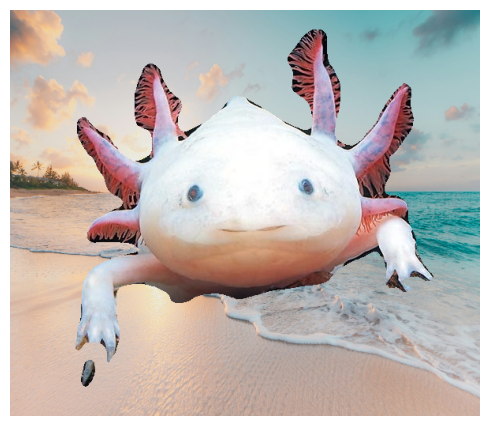

In [31]:
blurred = tool.get_blur(binary_mask)
result_img = tool.get_blend(img, bg, blurred)
tool.img_show(result_img)

## Step 3. 해결 방법을 제안해 보기

### CASE1 원본 이미지와 배경의 구분이 명확하지 않을 때
- 문제점 배경과 탐지할 객체의 구분이 모호하기 때문에 모델이 정확히 판단할 수 없음  
   softmax방식을 활용해 적절한 threshold값을 조절하는 것으로 외부 엣지를 구분할 수 있음
- 하지만, 현재 포즈에서 내부에 있는 배경을 제거하기에는 무리가 있다고 판단함

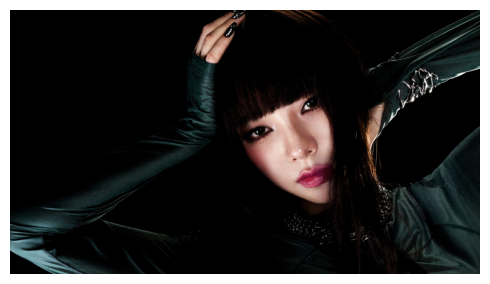

In [41]:
tool.img_show(img1)

In [33]:
raw_mask1_T, binary_mask1_T = tool.predict(img1, threshold=0.2)

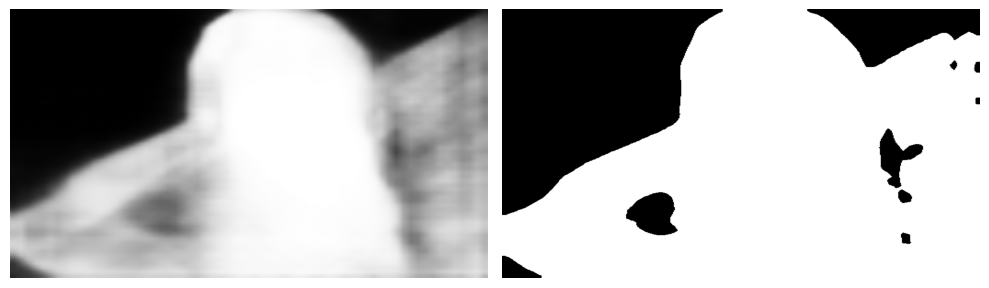

In [34]:
tool.img_show(raw_mask1_T, raw_mask1, is_mask=True, cmap = 'gray')

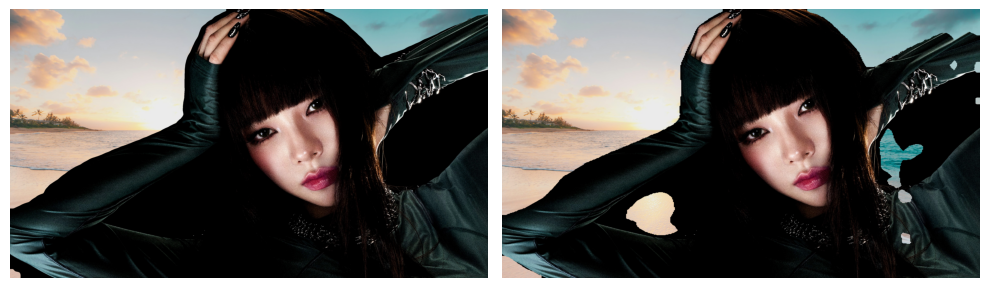

In [35]:
blurred1_T = tool.get_blur(binary_mask1_T)
result_img1_T = tool.get_blend(img1, bg, blurred1_T)
tool.img_show(result_img1_T, result_img1)

### CASE2 원본 이미지의 해상도가 낮은 경우
- 해상도를 resize한 다음 프레임 보간으로 빈공간을 채워서 모델의 입력을 준다  
      - 생각보다 프레임 보간이 해상도를 높여주진 않음
- 해상도가 낮은 이미지를 ai로 업스케일링 해서 모델의 입력으로 주기

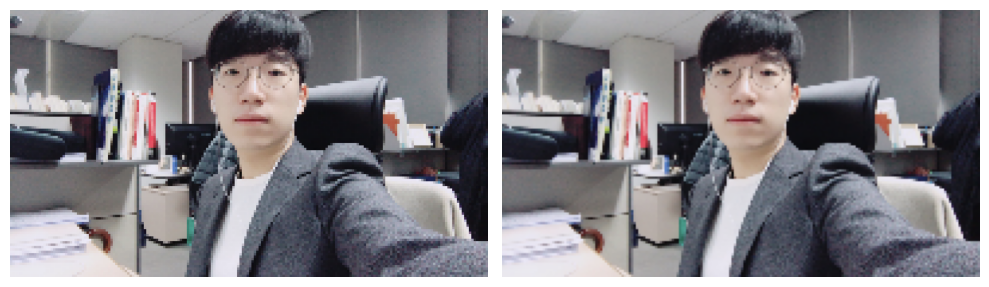

In [40]:
img2_up = cv2.resize(img2_resized, (0, 0), fx=4.0, fy=4.0, interpolation=cv2.INTER_NEAREST)
tool.img_show(img2_up, img2_resized)

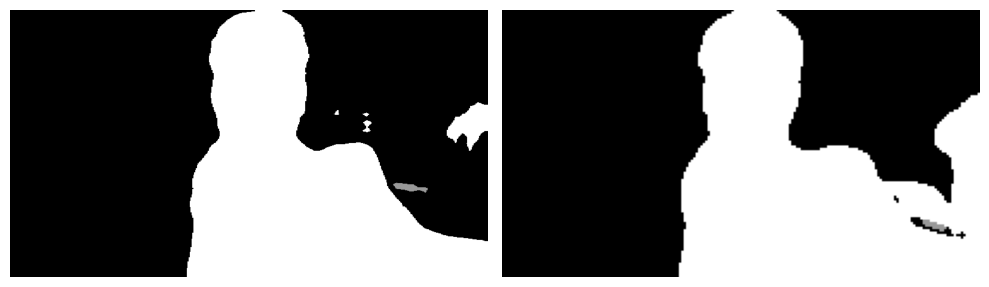

In [37]:
# 2. 마스크 추출 (핵심!)
raw_mask, binary_mask = tool.predict(img2_up)
tool.img_show(raw_mask, raw_mask_resized, is_mask=True, cmap = 'gray')

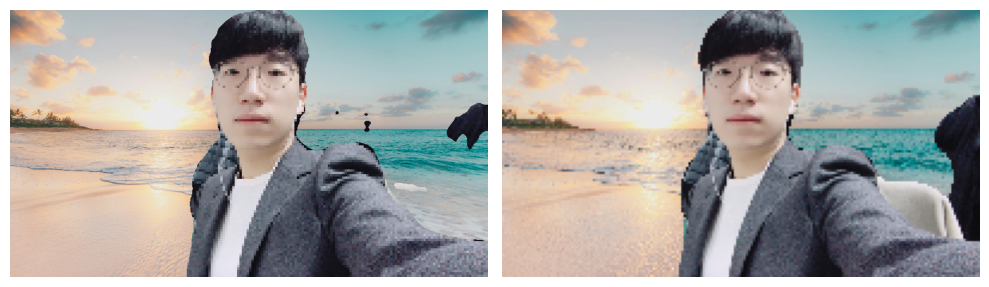

In [38]:
blurred = tool.get_blur(binary_mask)
result_img = tool.get_blend(img2_up, bg, blurred)
tool.img_show(result_img, result_img_resized)

### CASE3 - 학습되지 않은 클래스
- 학습되지 않은 클래스는 탐지할 클래스의 데이터를 수집 후 모델에 학습을 시키는 방법으로 문제를 해결할 수 있다.  
예를 들어 우파루파(Leucistic)와 같이 사전에 학습되지 않은 특정 클래스를 탐지하고자 한다면 
데이터를 별도로 준비해서 전처리 후 학습을 다시 시키면 된다.

## 개발 과정
1. 모델로 이미지의 특정 객체에 대한 클래스를 구분하고 다른 배경과 합성하기
2. 주어진 이미지의 특정 객체에 대한 블러 처리를 함 (전체 이미지, 배경만 블러, 탐지된 객체만 블러)
3. deeplabV3+모델의 적용 사례를 보여주면 문제점을 찾기
   - 배경의 구분이 명확하지 않고 탐지된 객체 내부에 있는 배경은 구분하기 어려움
   - 해상도가 낮은 경우 모델이 객체를 구분하기 어려움
   - 모델이 사전학습하지 않은 클래스를 구분하기 어려움
     
4. 이와 같은 문제점을 발견하고 해결방안 제안하기
      - [case1 모호한 경게](./images/source/img1.png)  
          - 왼쪽 사진(softmax) 오른쪽 사진(argnmax)
      - [case2 낮은 해상도](./images/source/img2.png)
          - 왼쪽 사진(up) 오른쪽 사진(down)